In [49]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

import sklearn.preprocessing
from pydataset import data
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import wrangle

<div class="alert alert-block alert-success">
    
# The Tips Dataset
</div>

In [70]:
tips=data('tips')

In [4]:
tips.head()

,total_bill,tip,sex,smoker,day,time,size
1,16.99,1.01,Female,No,Sun,Dinner,2
2,10.34,1.66,Male,No,Sun,Dinner,3
3,21.01,3.50,Male,No,Sun,Dinner,3
4,23.68,3.31,Male,No,Sun,Dinner,2
5,24.59,3.61,Female,No,Sun,Dinner,4


In [5]:
tips['price_per_person'] = (tips.total_bill / tips['size'])

In [6]:
tips.rename(columns={'size':'party_size'},inplace=True)

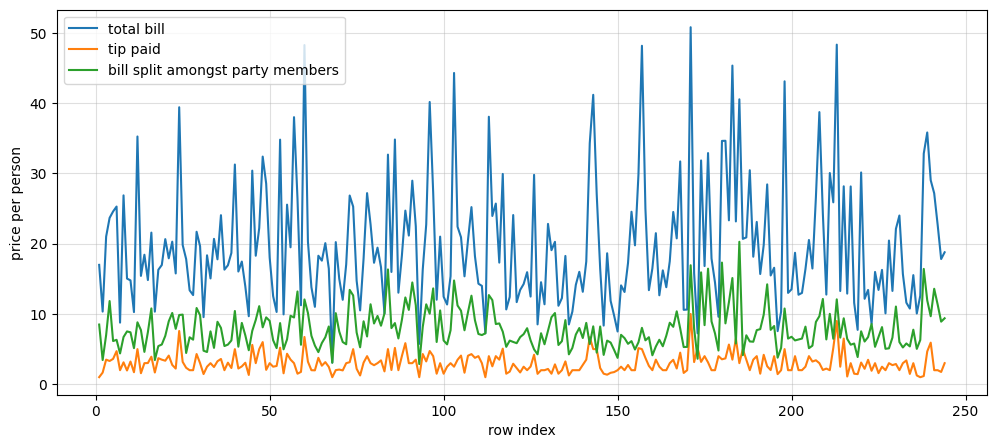

In [7]:
plt.figure(figsize=(12,5))
sns.lineplot(tips.total_bill,label='total bill')
sns.lineplot(tips.tip,label='tip paid')
sns.lineplot(tips.price_per_person,label='bill split amongst party members')
plt.grid(alpha=0.4)
plt.legend()
plt.ylabel('price per person')
plt.xlabel('row index')
plt.show()

<Axes: xlabel='day', ylabel='tip'>

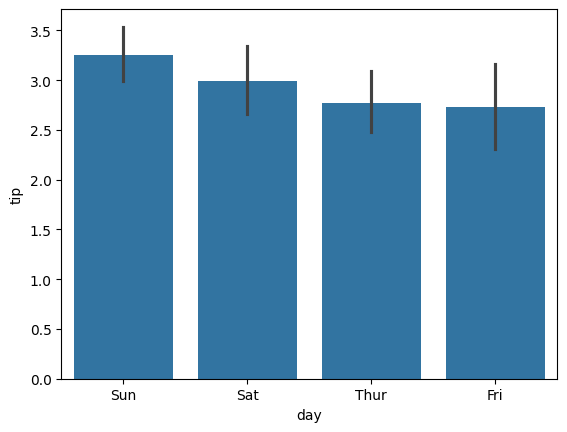

In [71]:
sns.barplot(x=tips.day,y=tips.tip)

In [8]:
dummies = pd.get_dummies(tips[['sex','smoker','day','time']], dummy_na=False, drop_first=[True, True]).astype(int)

In [9]:
tips = pd.concat([tips, dummies], axis=1)
tips = tips.drop(columns=['sex','smoker','day','time'])

In [10]:
tips.head()

,total_bill,tip,party_size,price_per_person,sex_Male,smoker_Yes,day_Sat,day_Sun,day_Thur,time_Lunch
1,16.99,1.01,2,8.495000,0,0,0,1,0,0
2,10.34,1.66,3,3.446667,1,0,0,1,0,0
3,21.01,3.50,3,7.003333,1,0,0,1,0,0
4,23.68,3.31,2,11.840000,1,0,0,1,0,0
5,24.59,3.61,4,6.147500,0,0,0,1,0,0


> ## total_bill seems to be the most important factor for tip amount according to experiences.


In [11]:
train,validate,test=wrangle.split_df(df=tips)

In [12]:
train.head()

,total_bill,tip,party_size,price_per_person,sex_Male,smoker_Yes,day_Sat,day_Sun,day_Thur,time_Lunch
37,16.31,2.00,3,5.436667,1,0,1,0,0,0
218,11.59,1.50,2,5.795000,1,1,1,0,0,0
64,18.29,3.76,4,4.572500,1,1,1,0,0,0
29,21.70,4.30,2,10.850000,1,0,1,0,0,0
14,18.43,3.00,4,4.607500,1,0,0,1,0,0


In [13]:
X_train = train.drop(columns=['tip'])
y_train = train['tip']

X_val= validate.drop(columns=['tip'])
y_val = validate['tip']

X_test = test.drop(columns=['tip'])
y_test = test['tip']

> ## KBest with unscaled data

In [14]:
f_selector = SelectKBest(f_regression,k=3)
f_selector.fit(X_train, y_train)

SelectKBest(k=3, score_func=<function f_regression at 0x146fce020>)

In [15]:
f_selector.get_feature_names_out()

array(['total_bill', 'party_size', 'price_per_person'], dtype=object)

In [16]:
score = np.array(f_selector.scores_)
name = np.array(X_train.columns)

In [18]:
list_of_score = list(zip(name, score))

In [38]:
rounded_score = [(name, round(score, 2)) for name, score in list_of_score ]
rounded_score

[('total_bill', 91.44),
 ('party_size', 29.3),
 ('price_per_person', 25.68),
 ('sex_Male', 1.23),
 ('smoker_Yes', 0.01),
 ('day_Sat', 0.13),
 ('day_Sun', 5.38),
 ('day_Thur', 2.88),
 ('time_Lunch', 3.79)]

> ## KBest with scaled data (robust)

In [22]:
scaler = sklearn.preprocessing.RobustScaler()

In [66]:
X_train_scaled = scaler.fit_transform(X_train)

In [44]:
f_selector = SelectKBest(f_regression, k=3)

In [45]:
f_selector.fit(X_train_scaled, y_train)

SelectKBest(k=3, score_func=<function f_regression at 0x146fce020>)

In [40]:
scores= np.array(f_selector.scores_)
names = np.array(X_train.columns)
list_of_scores = list(zip(names, scores))

In [43]:
rounded_scores = [(names, round(scores, 2)) for names, scores in list_of_scores ]
rounded_scores

[('total_bill', 91.44),
 ('party_size', 29.3),
 ('price_per_person', 25.68),
 ('sex_Male', 1.23),
 ('smoker_Yes', 0.01),
 ('day_Sat', 0.13),
 ('day_Sun', 5.38),
 ('day_Thur', 2.88),
 ('time_Lunch', 3.79)]

> # Recursive Feature Elimination - non-scaled

In [50]:
rfe = RFE(LinearRegression(), n_features_to_select=3)

In [52]:
X_rfe = rfe.fit_transform(X_train,y_train)  

In [53]:
lm = LinearRegression()
lm.fit(X_rfe,y_train)

LinearRegression()

In [55]:
rfe.get_feature_names_out()

array(['party_size', 'price_per_person', 'day_Sat'], dtype=object)

In [63]:
var_ranks = rfe.ranking_
var_names = X_train.columns.tolist()
pd.DataFrame({'Var': var_names, 'Rank': var_ranks})

,Var,Rank
0,total_bill,5
1,party_size,1
2,price_per_person,1
3,sex_Male,3
4,smoker_Yes,6
5,day_Sat,1
6,day_Sun,4
7,day_Thur,2
8,time_Lunch,7


> # Recursive Feature Elimination - scaled

In [65]:
X_rfe = rfe.fit_transform(X_train_scaled,y_train)  

In [67]:
lm = LinearRegression()
lm.fit(X_rfe,y_train)

LinearRegression()

In [68]:
var_ranks = rfe.ranking_
var_names = X_train.columns.tolist()
pd.DataFrame({'Var': var_names, 'Rank': var_ranks})

,Var,Rank
0,total_bill,1
1,party_size,1
2,price_per_person,1
3,sex_Male,4
4,smoker_Yes,6
5,day_Sat,2
6,day_Sun,5
7,day_Thur,3
8,time_Lunch,7


<div class="alert alert-block alert-success">
    
# The Swiss Dataset
</div>

In [74]:
swiss = data('swiss')

In [75]:
swiss.head()

,Fertility,Agriculture,Examination,Education,Catholic,Infant.Mortality
Courtelary,80.2,17.0,15,12,9.96,22.2
Delemont,83.1,45.1,6,9,84.84,22.2
Franches-Mnt,92.5,39.7,5,5,93.40,20.2
Moutier,85.8,36.5,12,7,33.77,20.3
Neuveville,76.9,43.5,17,15,5.16,20.6


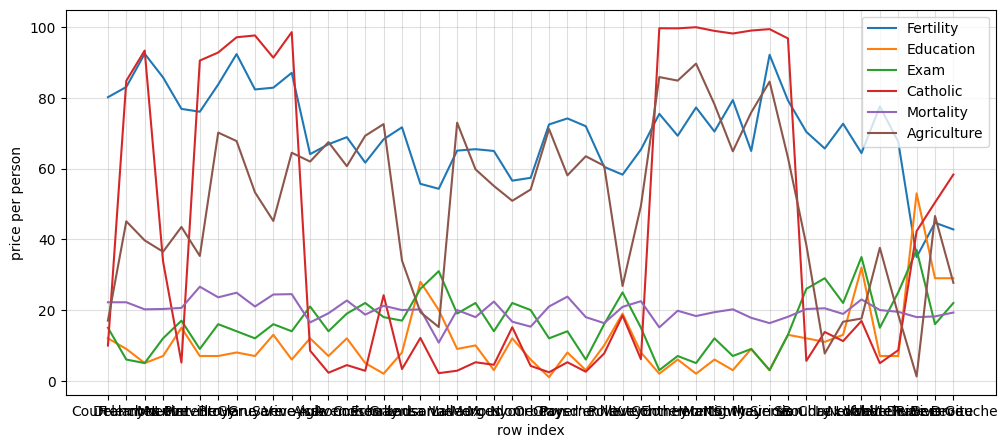

In [123]:
plt.figure(figsize=(12,5))
sns.lineplot(swiss.Fertility,label='Fertility')
sns.lineplot(swiss.Education,label='Education')
sns.lineplot(swiss.Examination,label='Exam')
sns.lineplot(swiss.Catholic,label='Catholic')
sns.lineplot(swiss['Infant.Mortality'],label='Mortality')
sns.lineplot(swiss.Agriculture,label='Agriculture')
plt.grid(alpha=0.4)
plt.legend()
plt.ylabel('price per person')
plt.xlabel('row index')
plt.show()

In [77]:
train,validate,test=wrangle.split_df(df=swiss)

In [81]:
X_train = train.drop(columns=['Fertility'])
y_train = train['Fertility']

X_val= validate.drop(columns=['Fertility'])
y_val = validate['Fertility']

X_test = test.drop(columns=['Fertility'])
y_test = test['Fertility']

> # KBest: Unscaled

In [82]:
f_selector_swiss = SelectKBest(f_regression,k=3)
f_selector_swiss.fit(X_train, y_train)
print(f_selector_swiss.get_feature_names_out())

swiss_score = np.array(f_selector_swiss.scores_)
swiss_col = np.array(X_train.columns)
list_of_scores = list(zip(swiss_col, swiss_score))
rounded_score = [(swiss_col, round(swiss_score, 2)) for swiss_col, swiss_score in list_of_scores]
rounded_score

['Examination' 'Education' 'Catholic']


[('Agriculture', 0.96),
 ('Examination', 10.28),
 ('Education', 14.06),
 ('Catholic', 4.93),
 ('Infant.Mortality', 4.61)]

> # KBest: Min-max scaled

In [91]:
scaler = sklearn.preprocessing.MinMaxScaler()
X_train_scaled=scaler.fit_transform(X_train)

In [98]:
f_selector_swiss = SelectKBest(f_regression,k=3)
f_selector_swiss.fit(X_train_scaled, y_train)

SelectKBest(k=3, score_func=<function f_regression at 0x146fce020>)

In [106]:
score=f_selector_swiss.scores_
name=X_train.columns
list_of_scores = list(zip(swiss_col, swiss_score))
list_of_scores = [(name, round(score, 2)) for name, score in list_of_scores]
list_of_scores

[('Agriculture', 0.96),
 ('Examination', 10.28),
 ('Education', 14.06),
 ('Catholic', 4.93),
 ('Infant.Mortality', 4.61)]

> # Recursive Feature Elimination - non-scaled

In [108]:
rfe = RFE(LinearRegression(), n_features_to_select=3)
X_rfe = rfe.fit_transform(X_train,y_train)  

lm = LinearRegression()
lm.fit(X_rfe,y_train)

rfe.get_feature_names_out()
var_ranks = rfe.ranking_
var_names = X_train.columns.tolist()
pd.DataFrame({'Var': var_names, 'Rank': var_ranks})

,Var,Rank
0,Agriculture,2
1,Examination,1
2,Education,1
3,Catholic,3
4,Infant.Mortality,1


> # Recursive Feature Elimination - scaled: Min-Max

In [110]:
rfe = RFE(LinearRegression(), n_features_to_select=3)
X_rfe = rfe.fit_transform(X_train_scaled,y_train)  

lm = LinearRegression()
lm.fit(X_rfe,y_train)

print(rfe.get_feature_names_out())
var_ranks = rfe.ranking_
var_names = X_train.columns.tolist()
pd.DataFrame({'Var': var_names, 'Rank': var_ranks})

['x1' 'x2' 'x4']


,Var,Rank
0,Agriculture,2
1,Examination,1
2,Education,1
3,Catholic,3
4,Infant.Mortality,1


> # Recursive Feature Elimination - scaled: Robust

In [112]:
scaler = sklearn.preprocessing.RobustScaler()
X_train_scaled=scaler.fit_transform(X_train)

In [113]:
rfe = RFE(LinearRegression(), n_features_to_select=3)
X_rfe = rfe.fit_transform(X_train_scaled,y_train)  

lm = LinearRegression()
lm.fit(X_rfe,y_train)

print(rfe.get_feature_names_out())
var_ranks = rfe.ranking_
var_names = X_train.columns.tolist()
pd.DataFrame({'Var': var_names, 'Rank': var_ranks})

['x0' 'x2' 'x3']


,Var,Rank
0,Agriculture,1
1,Examination,3
2,Education,1
3,Catholic,1
4,Infant.Mortality,2
